# Kara One - Transduction

## Load Dataset

In [2]:
from lib import KaraOneDataset

dataset_dir = "C:\\Users\\win8t\\OneDrive\\Desktop\\projects\\kara-one-transduction\\p"
dataset = KaraOneDataset(dataset_dir, scale_data=False, start_idx=0, end_idx=165)
# dataset = KaraOneDataset(dataset_dir, end_idx=3, scale_data=False, start_idx=1)

prompts: 165
PATH: C:\Users\win8t\OneDrive\Desktop\projects\kara-one-transduction\p\spoclab/users/szhao/EEG/data/MM05\Acquisition 232 Data.cnt
Reading 0 ... 2477399  =      0.000 ...  2477.399 secs...
EEG_RAW: <RawCNT | Acquisition 232 Data.cnt, 62 x 2477400 (2477.4 s), ~1.14 GB, data loaded>
Actual Length: 165
Calc: 0.793s 0 ['/uw/']
Calc: 0.770s 1 ['/tiy/']
Calc: 0.771s 2 ['/tiy/']
Calc: 0.764s 3 ['/uw/']
Calc: 0.761s 4 ['/iy/']
Calc: 0.823s 5 ['/m/']
Calc: 0.768s 6 ['/n/']
Calc: 0.776s 7 ['/iy/']
Calc: 0.782s 8 ['/n/']
Calc: 0.787s 9 ['/piy/']
Calc: 0.746s 10 ['/uw/']
Calc: 0.761s 11 ['/tiy/']
Calc: 0.767s 12 ['/iy/']
Calc: 0.773s 13 ['/diy/']
Calc: 0.779s 14 ['/n/']
Calc: 0.771s 15 ['/iy/']
Calc: 0.754s 16 ['/tiy/']
Calc: 0.744s 17 ['/piy/']
Calc: 0.757s 18 ['/tiy/']
Calc: 0.747s 19 ['/n/']
Calc: 0.768s 20 ['/m/']
Calc: 0.763s 21 ['/m/']
Calc: 0.780s 22 ['/diy/']
Calc: 0.740s 23 ['/uw/']
Calc: 0.749s 24 ['/piy/']
Calc: 0.762s 25 ['/tiy/']
Calc: 0.769s 26 ['/m/']
Calc: 0.778s 27 ['/

In [3]:
import numpy as np
i = 0
dataset[i]["eeg_vocal"].shape, dataset[i]["eeg_vocal_raw"].shape, dataset[i]["eeg_vocal_feats"].shape

0 165 C:\Users\win8t\OneDrive\Desktop\projects\kara-one-transduction\p\spoclab/users/szhao/EEG/data/MM05\kinect_data/0.wav
0 165 C:\Users\win8t\OneDrive\Desktop\projects\kara-one-transduction\p\spoclab/users/szhao/EEG/data/MM05\kinect_data/0.wav
0 165 C:\Users\win8t\OneDrive\Desktop\projects\kara-one-transduction\p\spoclab/users/szhao/EEG/data/MM05\kinect_data/0.wav


((1488,), (903, 62), (148, 310))

## Single Channel Analysis

From: [Paper](http://www.cs.toronto.edu/~complingweb/data/karaOne/ZhaoRudzicz15.pdf)

Pearson correlation coefficients between audio features and imagined speech EEG features

|Sensor | FC6    | FT8 |  C5 | CP3|  P3 |
| - | - | - | - | - | - |
|Mean r | 0.3781 | 0.3758 | 0.3728 | 0.3720 | 0.3696 |

| Sensor | T7 | CP5 | C3 | CP1 |C4 |
| - | - | - | - | - | - |
Mean r | 0.3686|  0.3685|  0.3659| 0.3626 |0.3623

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_eeg(eeg_type, target_channels, idx, feat=False):
    plt.rcParams["figure.figsize"] = (14, 9)

    if not target_channels:
        target_channels = dataset.eeg_data.ch_names
    
    print("target_channels:", target_channels)
    
    print(dataset.eeg_data)

    keep_idx_s = [dataset.eeg_data.ch_names.index(target_ch)
                for target_ch in target_channels]

    example = dataset[idx]
    print(example["label"])
    eeg_data = example[eeg_type]
    # eeg_data = eeg_data - eeg_data.mean(axis=1, keepdims=True)
    print("eeg data shape:", eeg_data.shape)

    if feat:
        eeg_data = np.asarray(np.split(eeg_data, 62))
    
    for idx in keep_idx_s:
        print("idx:", idx)
        label = dataset.eeg_data.ch_names[idx]
        if feat:
            data = eeg_data[idx, 16]
        else:
            # data = eeg_data[:903, idx]
            # data = eeg_data[:, idx]
            data = eeg_data[:, (idx*5)+1]
            # data = eeg_data[:, (idx*5)+2] # working (p_r, rms)
        data = data - data.mean(axis=0, keepdims=True)
        # print(eeg_data.shape)
        # print(data.shape, eeg_data.shape, eeg_data.shape[1] / 1000, data)
        print("CUR ELECTRODE DATA:", data.shape)
        plt.plot(data, label=label)
        print(len(data), len(data / max(data)))

    plt.legend(loc="upper left")
    # plt.axvspan(xmin=435, xmax=668, color="green", alpha=0.5)
    # plt.axvspan(xmin=451, xmax=553, color="red", alpha=0.5)
    # plt.axvspan(xmin=397, xmax=532, color="red", alpha=0.5)
    plt.show()

target_channels = "FC6 FT8 C5 CP3 P3 T7 CP5 C3 CP1 C4".split(" ") # top 10
# target_channels = "FC6 FT8 C5 CP3 CP5 C3 CP1 C4".split(" ") # top 10 - T7 (temporal 7?)
# target_channels = target_channels[0:10]
# target_channels = []

target_channels: ['FC6', 'FT8', 'C5', 'CP3', 'P3', 'T7', 'CP5', 'C3', 'CP1', 'C4']
<RawCNT | Acquisition 232 Data.cnt, 62 x 2477400 (2477.4 s), ~1.14 GB, data loaded>
0 100 C:\Users\win8t\OneDrive\Desktop\projects\kara-one-transduction\p\spoclab/users/szhao/EEG/data/MM05\kinect_data/0.wav
/uw/
eeg data shape: (148, 310)
idx: 21
CUR ELECTRODE DATA: (148,)
148 148
idx: 22
CUR ELECTRODE DATA: (148,)
148 148
idx: 24
CUR ELECTRODE DATA: (148,)
148 148
idx: 35
CUR ELECTRODE DATA: (148,)
148 148
idx: 45
CUR ELECTRODE DATA: (148,)
148 148
idx: 23
CUR ELECTRODE DATA: (148,)
148 148
idx: 34
CUR ELECTRODE DATA: (148,)
148 148
idx: 25
CUR ELECTRODE DATA: (148,)
148 148
idx: 36
CUR ELECTRODE DATA: (148,)
148 148
idx: 29
CUR ELECTRODE DATA: (148,)
148 148


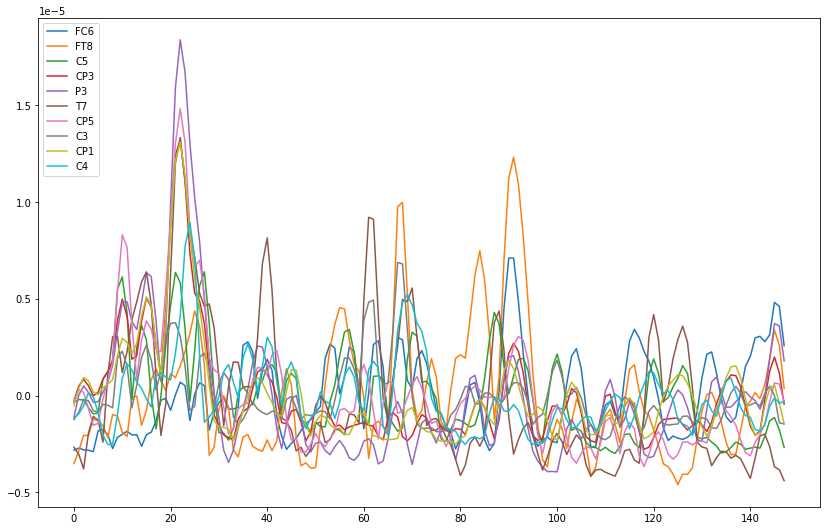

target_channels: ['FC6', 'FT8', 'C5', 'CP3', 'P3', 'T7', 'CP5', 'C3', 'CP1', 'C4']
<RawCNT | Acquisition 232 Data.cnt, 62 x 2477400 (2477.4 s), ~1.14 GB, data loaded>
0 100 C:\Users\win8t\OneDrive\Desktop\projects\kara-one-transduction\p\spoclab/users/szhao/EEG/data/MM05\kinect_data/0.wav
/uw/
eeg data shape: (444, 310)
idx: 21
CUR ELECTRODE DATA: (444,)
444 444
idx: 22
CUR ELECTRODE DATA: (444,)
444 444
idx: 24
CUR ELECTRODE DATA: (444,)
444 444
idx: 35
CUR ELECTRODE DATA: (444,)
444 444
idx: 45
CUR ELECTRODE DATA: (444,)
444 444
idx: 23
CUR ELECTRODE DATA: (444,)
444 444
idx: 34
CUR ELECTRODE DATA: (444,)
444 444
idx: 25
CUR ELECTRODE DATA: (444,)
444 444
idx: 36
CUR ELECTRODE DATA: (444,)
444 444
idx: 29
CUR ELECTRODE DATA: (444,)
444 444


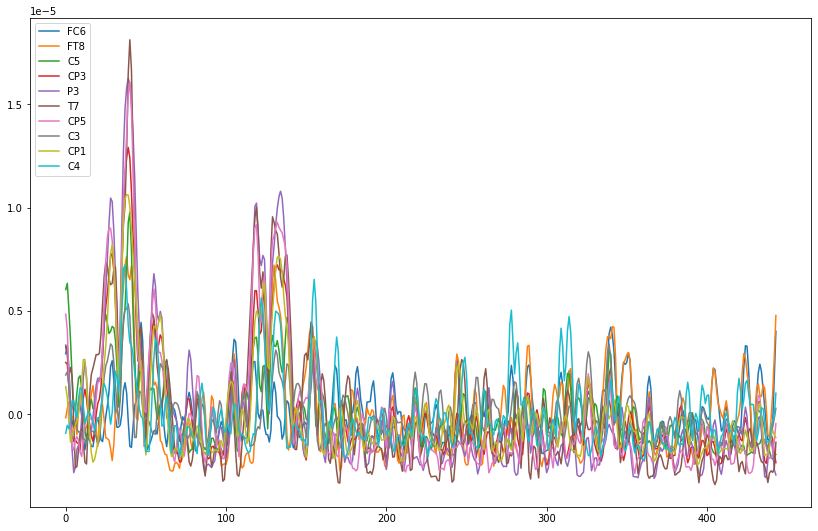

target_channels: ['FC6', 'FT8', 'C5', 'CP3', 'P3', 'T7', 'CP5', 'C3', 'CP1', 'C4']
<RawCNT | Acquisition 232 Data.cnt, 62 x 2477400 (2477.4 s), ~1.14 GB, data loaded>
0 100 C:\Users\win8t\OneDrive\Desktop\projects\kara-one-transduction\p\spoclab/users/szhao/EEG/data/MM05\kinect_data/1.wav
/tiy/
eeg data shape: (198, 310)
idx: 21
CUR ELECTRODE DATA: (198,)
198 198
idx: 22
CUR ELECTRODE DATA: (198,)
198 198
idx: 24
CUR ELECTRODE DATA: (198,)
198 198
idx: 35
CUR ELECTRODE DATA: (198,)
198 198
idx: 45
CUR ELECTRODE DATA: (198,)
198 198
idx: 23
CUR ELECTRODE DATA: (198,)
198 198
idx: 34
CUR ELECTRODE DATA: (198,)
198 198
idx: 25
CUR ELECTRODE DATA: (198,)
198 198
idx: 36
CUR ELECTRODE DATA: (198,)
198 198
idx: 29
CUR ELECTRODE DATA: (198,)
198 198


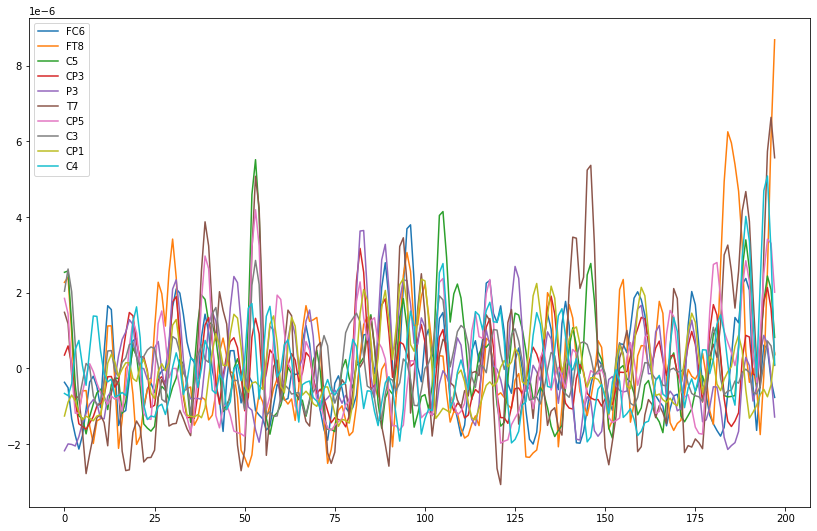

target_channels: ['FC6', 'FT8', 'C5', 'CP3', 'P3', 'T7', 'CP5', 'C3', 'CP1', 'C4']
<RawCNT | Acquisition 232 Data.cnt, 62 x 2477400 (2477.4 s), ~1.14 GB, data loaded>
0 100 C:\Users\win8t\OneDrive\Desktop\projects\kara-one-transduction\p\spoclab/users/szhao/EEG/data/MM05\kinect_data/1.wav
/tiy/
eeg data shape: (445, 310)
idx: 21
CUR ELECTRODE DATA: (445,)
445 445
idx: 22
CUR ELECTRODE DATA: (445,)
445 445
idx: 24
CUR ELECTRODE DATA: (445,)
445 445
idx: 35
CUR ELECTRODE DATA: (445,)
445 445
idx: 45
CUR ELECTRODE DATA: (445,)
445 445
idx: 23
CUR ELECTRODE DATA: (445,)
445 445
idx: 34
CUR ELECTRODE DATA: (445,)
445 445
idx: 25
CUR ELECTRODE DATA: (445,)
445 445
idx: 36
CUR ELECTRODE DATA: (445,)
445 445
idx: 29
CUR ELECTRODE DATA: (445,)
445 445


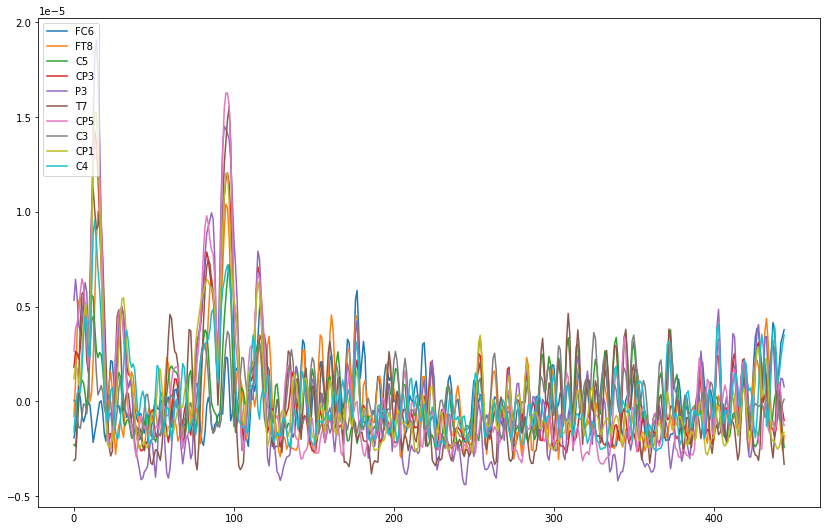

In [4]:
for i in [0,1]:
    plot_eeg("eeg_vocal_feats", target_channels, idx=i, feat=False)
    plot_eeg("eeg_active_feats", target_channels, idx=i, feat=False)
# target_channels

### Audio Visualisation

0 165 C:\Users\win8t\OneDrive\Desktop\projects\kara-one-transduction\p\spoclab/users/szhao/EEG/data/MM05\kinect_data/0.wav


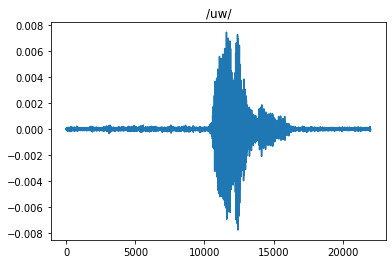

1.376
0 165 C:\Users\win8t\OneDrive\Desktop\projects\kara-one-transduction\p\spoclab/users/szhao/EEG/data/MM05\kinect_data/1.wav


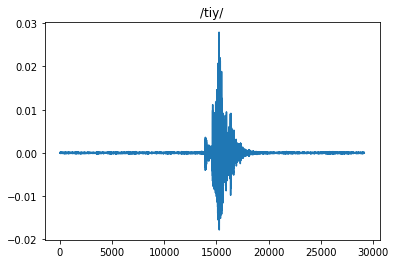

1.824


In [5]:
for i in [0, 1]:
    example = dataset[i]
    plt.title(example["label"])
    plt.plot(example["audio_raw"])
    plt.show()
    print(len(example["audio_raw"]) / 16_000)

### Mel Spectrogram of Audio (Vocalised)

In [6]:
from matplotlib import cm

def plot_mel_spectrogram(mel_spec, title):
    fig, ax = plt.subplots(1)

    ax.set_title(f"Mel Spectogram \"{title}\"")
    pred = np.swapaxes(mel_spec, 0, 1)
    cax = ax.imshow(pred, interpolation='nearest', cmap=cm.coolwarm, origin='lower')

    return fig

0 165 C:\Users\win8t\OneDrive\Desktop\projects\kara-one-transduction\p\spoclab/users/szhao/EEG/data/MM05\kinect_data/0.wav
(135, 128)
0 165 C:\Users\win8t\OneDrive\Desktop\projects\kara-one-transduction\p\spoclab/users/szhao/EEG/data/MM05\kinect_data/0.wav
0 165 C:\Users\win8t\OneDrive\Desktop\projects\kara-one-transduction\p\spoclab/users/szhao/EEG/data/MM05\kinect_data/1.wav
(180, 128)
0 165 C:\Users\win8t\OneDrive\Desktop\projects\kara-one-transduction\p\spoclab/users/szhao/EEG/data/MM05\kinect_data/1.wav


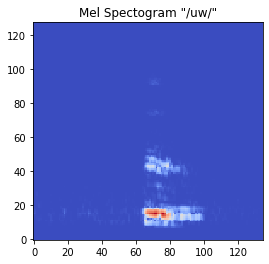

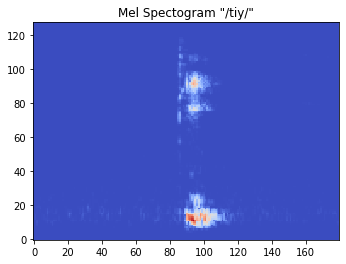

In [7]:
for i in [0, 1]: # range(1):
    example_mel_spec = dataset[i]["audio_feats"]
    print(example_mel_spec.shape)
    plot_mel_spectrogram(example_mel_spec, dataset[i]["label"])

## Single Synthesis (Overfit)

### Model

In [106]:
# synth_examples = [dataset[0], dataset[1]]

synth_example = dataset[0]

import torch
import random

from lib.transduction import DigitalVoicingModel

electrode_slice = 62 # 62
ins = 5 * electrode_slice # 5 hand-crafted features * 62 electrodes
outs = 128 # n mels

device = "cuda" if torch.cuda.is_available() else "cpu"

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

model = DigitalVoicingModel(
    ins=ins,
    model_size=128,
    n_layers=1,
    dropout=0.0,
    outs=outs).to(device)

1 3 C:\Users\win8t\OneDrive\Desktop\projects\kara-one-transduction\p\spoclab/users/szhao/EEG/data/MM05\kinect_data/1.wav
1 3 C:\Users\win8t\OneDrive\Desktop\projects\kara-one-transduction\p\spoclab/users/szhao/EEG/data/MM05\kinect_data/2.wav


### Training

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.cuda.amp.grad_scaler import GradScaler

import matplotlib.pyplot as plt

X = torch.tensor(synth_example["eeg_vocal_feats"]).to(device)
y = torch.tensor(synth_example["audio_feats"]).to(device)

# clip sizes to smallest of both
clip_len = min(X.shape[0], y.shape[0])

X = X[:clip_len, :ins]
y = y[:clip_len, :]

print(X.shape, y.shape)

X = torch.unsqueeze(X, 0)
y = torch.unsqueeze(y, 0)

# NOTE: 5e-4 at 20,000 epochs for vocal, 1e-3 at 10,000 epochs for imagined
lr = 5e-4 # 1e-3 # 5e-4 # 1e-3
optim = torch.optim.Adam(model.parameters(), lr=lr)

amp = True

epochs = 20_000 # 20_000 # 10_000

scaler = GradScaler()

criteria = nn.MSELoss()

pred_s = []
losses = []

# scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1000, gamma=0.1)

for i in range(epochs):
    # optim.zero_grad()

    with torch.autocast(
        enabled=amp,
        dtype=torch.bfloat16,
        device_type=device):

        pred = model(X)
        loss = criteria(pred, y)

        if i % 100 == 0:
            pred_s.append(pred.cpu().detach())
            losses.append(loss.item())

        # plt.plot(loss.item())

            print(i, loss.item())

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()

    # scheduler.step()

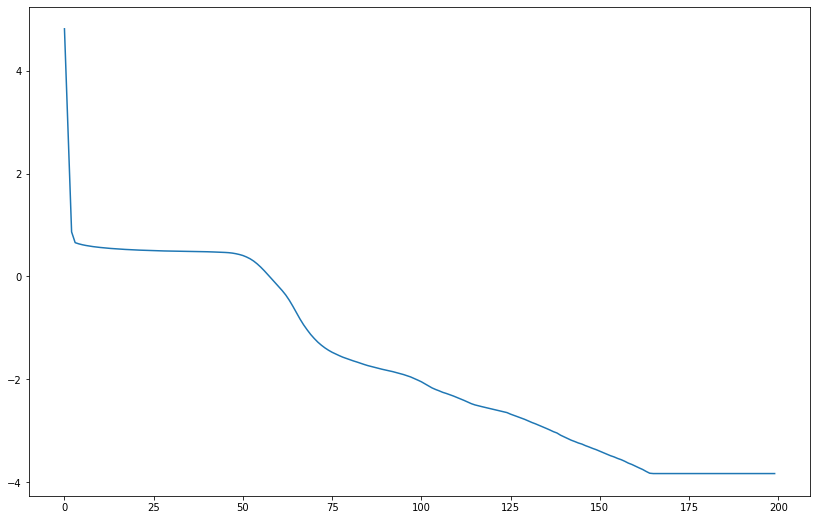

In [70]:
plt.plot(np.log(losses))

### Plot Pred

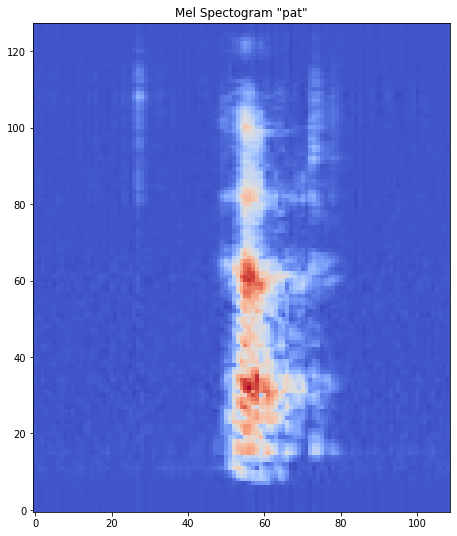

In [71]:
plt.rcParams["figure.figsize"] = (14, 9)

y = torch.squeeze(pred_s[len(pred_s) - 1], 0).float()
_ = plot_mel_spectrogram(y, synth_example["label"])

### Plot Original

161 162 C:\Users\win8t\OneDrive\Desktop\projects\kara-one-transduction\p\spoclab/users/szhao/EEG/data/MM05\kinect_data/161.wav


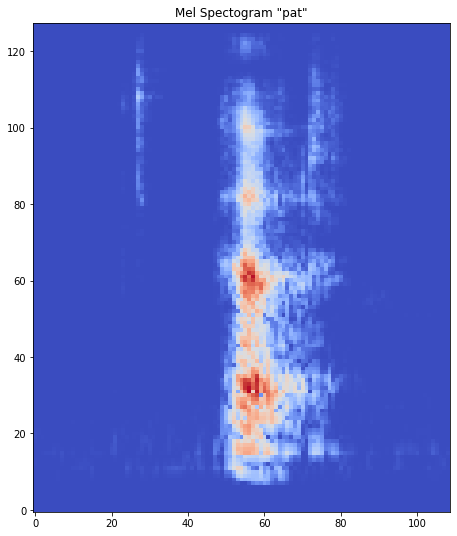

In [72]:
cur_ex = dataset[0]
_ = plot_mel_spectrogram(cur_ex["audio_feats"], cur_ex["label"])

## Multiple Synthesis (Overfit)

### Model

In [347]:
%%capture ignore

# Ignore data sample loading text

import torch
import random

from lib.transduction import DigitalVoicingModel

target_labels = ["/iy/", "/uw/"]
synth_examples = [data for data in dataset if data["label"] in target_labels]
#synth_examples = [data for data in dataset]
#synth_examples = synth_examples[0:len(synth_examples)] # [:105]
[print(eg["label"]) for eg in synth_examples]

electrode_slice = 62 # 62
ins = 5 * electrode_slice # 5 hand-crafted features * 62 electrodes
outs = 128 # n mels

device = "cuda" if torch.cuda.is_available() else "cpu"

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

model = DigitalVoicingModel(
    ins=ins,
    model_size=64,
    n_layers=1,
    dropout=0.0,
    outs=outs).to(device)

### Training

In [348]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.cuda.amp.grad_scaler import GradScaler

import matplotlib.pyplot as plt

X_s = []
y_s = []

for synth_example in synth_examples:
    # X = torch.tensor(synth_example["eeg_vocal_feats"]).to(device)
    X = torch.tensor(synth_example["eeg_active_feats"]).to(device)
    y = torch.tensor(synth_example["audio_feats"]).to(device)
    clip_len = min(X.shape[0], y.shape[0])
    X = X[:clip_len, :ins]
    y = y[:clip_len, :]
    X = torch.unsqueeze(X, 0)
    y = torch.unsqueeze(y, 0)
    X_s.append(X)
    y_s.append(y)

# NOTE: 5e-4 for vocal EEG looked promising, try running for longer if ReduceLROnPlateau doesn't work
# NOTE: 1e-3 (0-1500), 5e-4 (1500-3000), 5e-4 (3000-4500)
lr = 5e-4 # 1e-3 # 5e-4 # 1e-3
optim = torch.optim.Adam(model.parameters(), lr=lr)

amp = True

# 4k
epochs = 4_000 # 20_000

scaler = GradScaler()

criteria = nn.MSELoss()

pred_s = []
losses = []

# scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1500, gamma=0.5)

model.train()

for i in range(epochs):
    # optim.zero_grad()

    cur_losses = []

    for X, y in zip(X_s, y_s):
        with torch.autocast(
            enabled=amp,
            dtype=torch.bfloat16,
            device_type=device):

            pred = model(X) 
            loss = criteria(pred, y)
            cur_losses.append(loss)
    
    loss = sum(cur_losses)

    if i % 100 == 0:
        losses.append(loss.item())
        print(i, loss.item())

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()

    # scheduler.step()

0 3880.4306640625
100 576.802490234375
200 44.16455841064453
300 21.79228973388672
400 20.672204971313477
500 20.006837844848633
600 19.463579177856445
700 19.013057708740234
800 18.626007080078125
900 18.295604705810547


### Testing

In [306]:
out_s = []

model.eval()

for X, y in zip(X_s, y_s):
    with torch.no_grad():
        pred = model(X)
        out_s.append(pred.cpu().detach())

([<matplotlib.lines.Line2D at 0x24eff48a220>], 165)

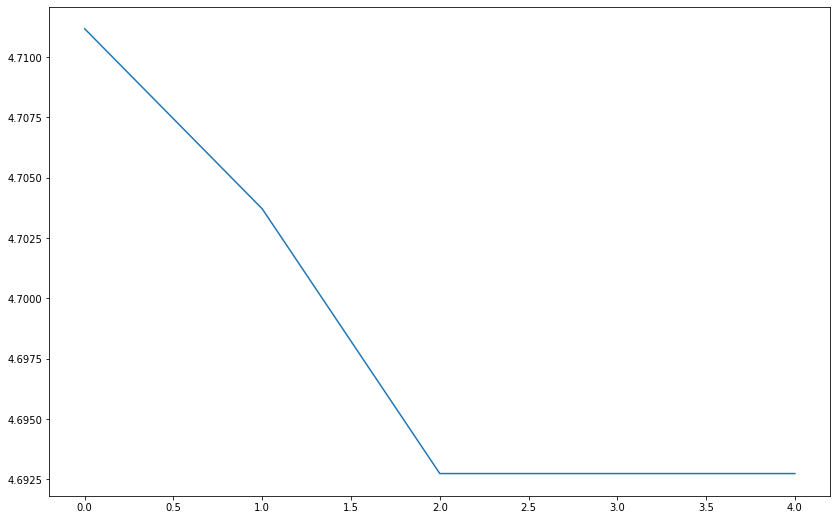

In [307]:
plt.plot(np.log(losses)), len(out_s)

### Plot Pred

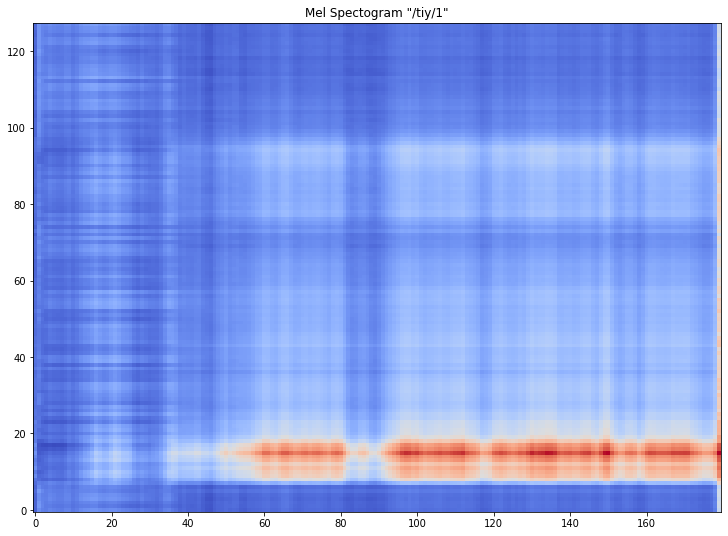

In [314]:
plt.rcParams["figure.figsize"] = (14, 9)

plot_pred_idx = 1
y = torch.squeeze(out_s[plot_pred_idx], 0).float()
_ = plot_mel_spectrogram(y, synth_examples[plot_pred_idx]["label"] + str(plot_pred_idx))

### Plot Original

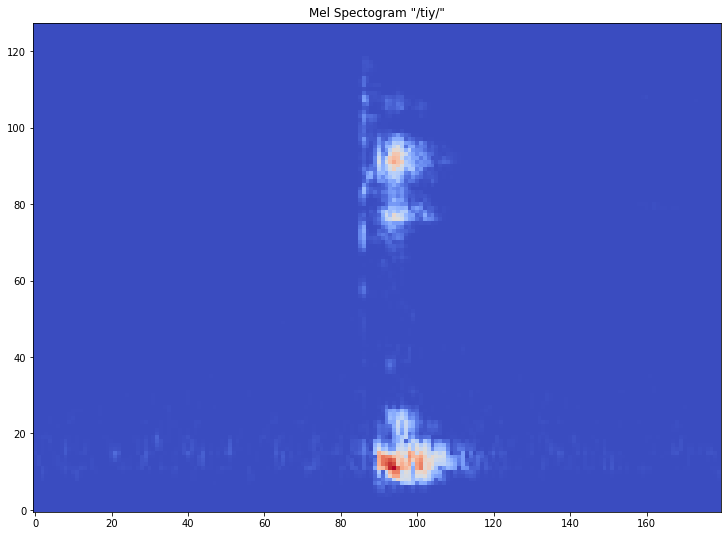

In [315]:
_ = plot_mel_spectrogram(synth_examples[plot_pred_idx]["audio_feats"], synth_examples[plot_pred_idx]["label"])

## Single Phoneme/Word Synthesis (Generalisation)

### Model

In [70]:
%%capture ignore

# Ignore data sample loading text

import torch
import random

from lib.transduction import DigitalVoicingModel

synth_examples = [data for data in dataset if data["label"] == "/tiy/"]
synth_examples = synth_examples[0:len(synth_examples)]
# synth_examples = [dataset[1], dataset[2], dataset[11]]
[print(eg["label"]) for eg in synth_examples]

trainset = synth_examples[0:12]
testset  = synth_examples[12:]

electrode_slice = 62 # 62
ins = 5 * electrode_slice # 5 hand-crafted features * 62 electrodes
outs = 128 # n mels

device = "cuda" if torch.cuda.is_available() else "cpu"

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

model = DigitalVoicingModel(
    ins=ins,
    model_size=64,
    n_layers=1,
    dropout=0.0,
    outs=outs).to(device)

### Train

In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.cuda.amp.grad_scaler import GradScaler

import matplotlib.pyplot as plt

def fillset(synth_examples):
    X_s = []
    y_s = []
    for synth_example in synth_examples:
        # X = torch.tensor(synth_example["eeg_vocal_feats"]).to(device)
        X = torch.tensor(synth_example["eeg_active_feats"]).to(device)
        y = torch.tensor(synth_example["audio_feats"]).to(device)
        clip_len = min(X.shape[0], y.shape[0])
        X = X[:clip_len, :ins]
        y = y[:clip_len, :]
        X = torch.unsqueeze(X, 0)
        y = torch.unsqueeze(y, 0)
        X_s.append(X)
        y_s.append(y)
    return X_s, y_s

train_X_s, train_y_s = fillset(trainset)
test_X_s,  test_y_s  = fillset(testset)

lr = 5e-4 # 1e-3
optim = torch.optim.Adam(model.parameters(), lr=lr)

amp = True

# 1k + ...
epochs = 10_000

scaler = GradScaler()

criteria = nn.MSELoss()

pred_s  = []
losses  = []
vlosses = []

def test(model):
    model.eval()

    cur_losses = []

    for X, y in zip(test_X_s, test_y_s):
        with torch.no_grad():
            pred = model(X)
            loss = criteria(pred, y)
            cur_losses.append(loss)

    loss = sum(cur_losses)

    return loss.item()

def train(model): # , scheduler):
    model.train()

    # optim.zero_grad()

    cur_losses = []

    for X, y in zip(train_X_s, train_y_s):
        with torch.autocast(
            enabled=amp,
            dtype=torch.bfloat16,
            device_type=device):

            pred = model(X) 
            loss = criteria(pred, y)
            cur_losses.append(loss)
    
    loss = sum(cur_losses)

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()

    # scheduler.step()

    return loss.item()

def run(model):
    # scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1000, gamma=0.1)

    for i in range(epochs):
        train_loss = train(model) # , scheduler)
        
        if i % 100 == 0:
            losses.append(train_loss)
            test_loss = test(model)
            vlosses.append(test_loss)
            print(i, train_loss, test_loss)

run(model)

0 3.4249348640441895 1.8846848011016846
100 3.4249348640441895 1.8846848011016846


KeyboardInterrupt: 

#### Save Model

In [78]:
model_params_copy = model.state_dict().copy()

In [88]:
model.load_state_dict(model_params_copy)

<All keys matched successfully>

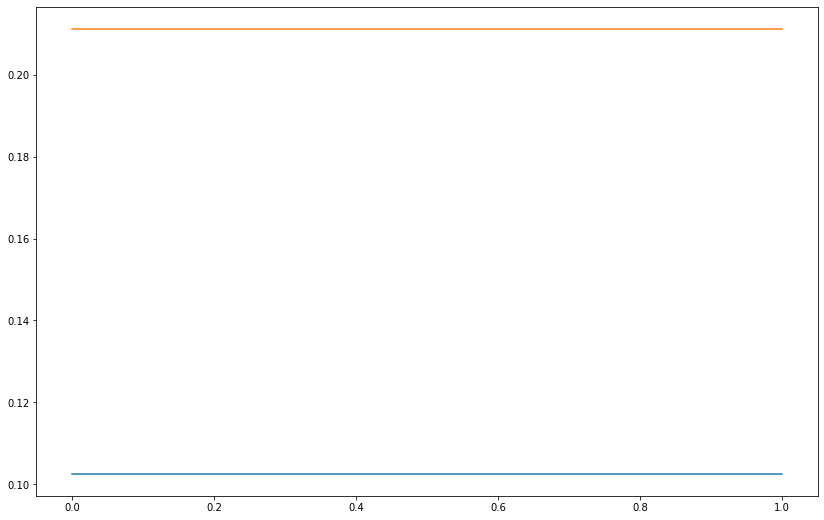

In [90]:
plt.plot(np.log(losses) / len(trainset))
plt.plot(np.log(vlosses) / len(testset))

### Evaluate

#### Generate Predictions

In [91]:
out_s = []

model.eval()

for X, y in zip(test_X_s, test_y_s):
    with torch.no_grad():
        pred = model(X)
        out_s.append(pred.cpu().detach())

#### Plot Prediction

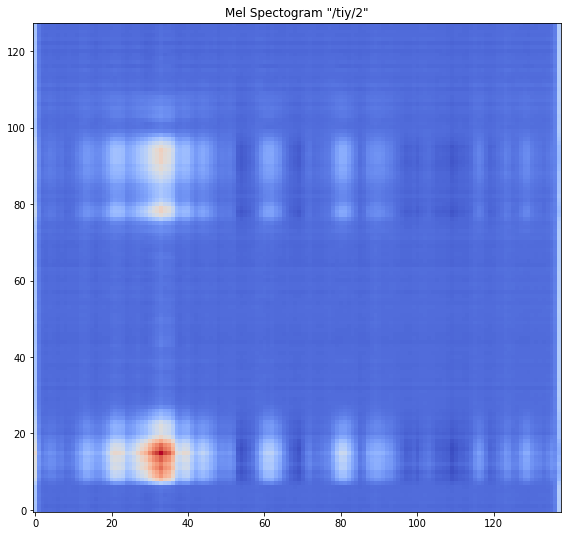

In [96]:
plt.rcParams["figure.figsize"] = (14, 9)

plot_pred_idx = 2
y = torch.squeeze(out_s[plot_pred_idx], 0).float()
_ = plot_mel_spectrogram(y, testset[plot_pred_idx]["label"] + str(plot_pred_idx))

#### Plot Original

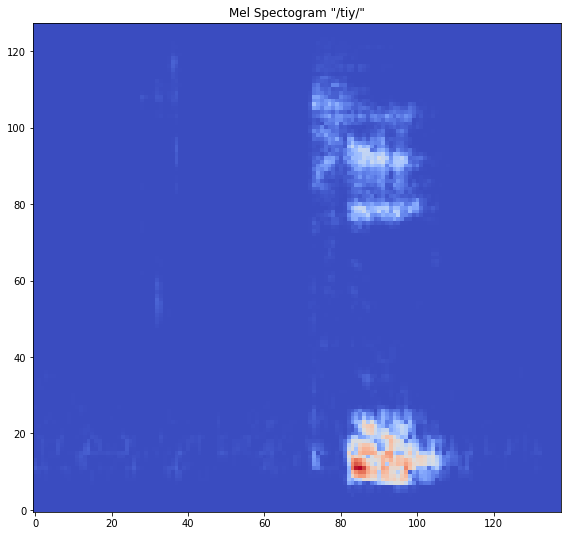

In [97]:
_ = plot_mel_spectrogram(
    testset[plot_pred_idx]["audio_feats"],
    testset[plot_pred_idx]["label"])